# Categorização de Compras

# Importa Bibliotecas

In [1]:
from getpass import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from swat import *
# import dlpy
# from dlpy.timeseries import plot_timeseries
# from dlpy.splitting import two_way_split
# from dlpy import Sequential
# from dlpy.layers import * 
# from dlpy.model import Optimizer, AdamSolver, Sequence
import dlpy
from dlpy import *
from dlpy import Sequential
from dlpy.splitting import three_way_split
from dlpy.model import TextParms
from dlpy.blocks import Bidirectional
from dlpy.applications import TextClassification
from dlpy.metrics import accuracy_score, roc_auc_score, confusion_matrix
%matplotlib inline

# Connect to SAS Viya

In [2]:
sas = CAS('localhost', 5570, 'sasdemo', getpass('Please enter your passwod:'))

Please enter your passwod:········


# Load Action Sets

In [3]:
sas.loadactionset('fedSql')
sas.loadactionset('sampling')
print('Done!')

NOTE: Added action set 'fedSql'.
NOTE: Added action set 'sampling'.
Done!


# Load Data

In [4]:
des = sas.read_csv('/home/sasdemo/demos/nlpCompras/data/ComprasDesc.csv',
                   sep=',',
                   quotechar='"',
                   casout=CASTable(name='des', replace=True))
print(des.columns)
print(des.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table DES in caslib CASUSER(sasdemo).
NOTE: The table DES has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['DESCRI', 'NCM'], dtype='object')
(163933, 2)


In [5]:
des.head()

,DESCRI,NCM
0,- REEF.: (140330) - SPRAY CAPILAR 270ML - TIGI...,33059000.0
1,- REF.: (00121-20-1) - BRILHO LABIAL 2.6G - PE...,33041000.0
2,- REF.: (00122-20-1) - BRILHO LABIAL 2.6G- CAR...,33041000.0
3,- REF.: (00217-20) - LOCAO DE LIMPEZA CLEANSER...,33049910.0
4,- REF.: (00372-20) - CREME PARA MAOS 70G - BUR...,33049910.0


In [6]:
cat = sas.read_csv('/home/sasdemo/demos/nlpCompras/data/ComprasCat2.csv',
                   sep=',',
                   quotechar='"',
                   casout=CASTable(name='cat', replace=True))
print(cat.columns)
print(cat.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table CAT in caslib CASUSER(sasdemo).
NOTE: The table CAT has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['ncm', 'cat'], dtype='object')
(6, 2)


In [7]:
cat.head()

,ncm,cat
0,33.0,ÓLEOS
1,34.0,SABÕES
2,96.0,OBRAS DIVERSAS
3,48.0,PAPÉIS
4,39.0,PLÁSTICOS


# Target Definition

In [8]:
sas.fedsql.execdirect(
    '''
    create table data {options replace=True} as select
        a.DESCRI as DES,
        nvl(b.CAT,'OUTROS') as CAT
    from des as a
    left join cat as b
    on floor(a.NCM/1e6) = b.NCM
    '''
)
data = sas.CASTable('data')
print(data.columns)
print(data.shape)

NOTE: Table DATA was created in caslib CASUSER(sasdemo) with 163933 rows returned.
Index(['DES', 'CAT'], dtype='object')
(163933, 2)


In [9]:
data.head()

,DES,CAT
0,- REEF.: (140330) - SPRAY CAPILAR 270ML - TIGI...,ÓLEOS
1,- REF.: (00121-20-1) - BRILHO LABIAL 2.6G - PE...,ÓLEOS
2,- REF.: (00122-20-1) - BRILHO LABIAL 2.6G- CAR...,ÓLEOS
3,- REF.: (00217-20) - LOCAO DE LIMPEZA CLEANSER...,ÓLEOS
4,- REF.: (00372-20) - CREME PARA MAOS 70G - BUR...,ÓLEOS


In [10]:
sas.fedsql.execdirect(
    '''
    select cat, sum(1) as cnt from data group by cat order by cnt desc
    '''
)

,CAT,CNT
0,ÓLEOS,131954
1,SABÕES,11886
2,OBRAS DIVERSAS,9464
3,OUTROS,2971
4,PAPÉIS,2958
5,PLÁSTICOS,2505
6,FERRAMENTAS,2195


# Stratified Sampling

In [11]:
data.groupby('cat') \
    .stratified(output={'casOut':{'name':'data', 'replace':True}, 'copyVars':'ALL'},
                samppct=80,
                samppct2=10,
                partind=True)

NOTE: Using SEED=1808929504 for sampling.


[outputSize]

 {'outputNObs': 163933.0, 'outputNVars': 3}

[STRAFreq]

 Frequencies
 
    ByGrpID             CAT    NObs  NSamp1  NSamp2
 0        0     FERRAMENTAS    2195    1756     220
 1        1  OBRAS DIVERSAS    9464    7572     946
 2        2           ÓLEOS  131954  105564   13195
 3        3          OUTROS    2971    2377     297
 4        4          PAPÉIS    2958    2366     296
 5        5       PLÁSTICOS    2505    2004     251
 6        6          SABÕES   11886    9508    1189

[OutputCasTables]

              casLib  Name Label    Rows  Columns  \
 0  CASUSER(sasdemo)  data        163933        3   
 
                                       casTable  
 0  CASTable('data', caslib='CASUSER(sasdemo)')  

+ Elapsed: 0.0715s, user: 0.147s, sys: 0.042s, mem: 38.4mb

# Load Embeddings

Repositório de Word Embeddings do NILC (Núcleo Interinstitucional de Linguística Computacional)
- http://nilc.icmc.usp.br/embeddings

In [12]:
emb = sas.read_csv('/home/sasdemo/demos/nlpCompras/data/glove_s50.txt',
                   sep=' ',
                   header=None,
                   skiprows=1,
                   casout=CASTable(name='emb', replace=True))
print(emb.columns)
print(emb.shape)

NOTE: Cloud Analytic Services made the uploaded file available as table EMB in caslib CASUSER(sasdemo).
NOTE: The table EMB has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50'],
      dtype='object')
(929605, 51)


In [13]:
emb.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,bach-ensemble,0.185962,0.005403,0.034411,0.230161,-0.048013,-0.157347,-0.178815,0.166236,0.233999,...,-0.151531,0.058163,0.173257,0.110510,-0.068603,-0.246021,0.089480,-0.167036,0.078223,0.086510
1,bachakademie,0.262665,-0.007878,0.106710,0.366453,-0.162965,0.023489,-0.154169,0.054165,0.398305,...,-0.179373,0.138628,-0.005723,-0.090575,-0.302942,0.001275,0.067189,-0.040638,0.186171,0.047528
2,bachan,0.171704,0.135297,-0.189762,0.461116,-0.023671,0.118860,-0.118285,0.067270,0.084439,...,-0.045359,0.086998,0.048135,-0.142161,0.150860,0.031589,0.119561,-0.049655,0.095325,0.019461
3,bacharelete,0.220850,0.021584,-0.081730,0.395438,-0.036521,-0.119953,0.122342,0.421450,-0.030971,...,-0.162786,-0.040663,0.043406,-0.035341,-0.066914,0.056264,0.048038,-0.023013,-0.046183,0.153120
4,bachianos,0.402011,0.260384,-0.361664,0.397158,-0.159648,-0.191939,-0.089854,-0.133350,0.132191,...,-0.126262,0.048381,0.213197,-0.045261,0.073318,0.071142,0.093491,0.058454,-0.108257,-0.137445


# Train Model

In [67]:
model = TextClassification(sas,
                           model_table='bdlstm001',
                           neurons=25,
                           n_blocks=1,
                           rnn_type='LSTM')

NOTE: Output layer added.
NOTE: Model compiled successfully.


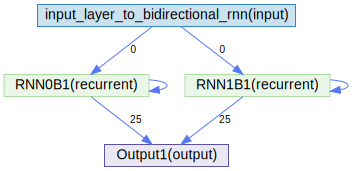

In [68]:
model.plot_network()

In [69]:
model.fit(data=data[data['_PartInd_']==0 and data['cat']!='ÓLEOS'], 
          valid_table=data[data['_PartInd_']==1 and data['cat']!='ÓLEOS'],
          inputs='des',
          texts='des',
          target='cat',
          nominals='cat',
          text_parms=TextParms(init_input_embeddings='emb', language='portuguese'),
          mini_batch_size=4, 
          max_epochs=100,
          lr=0.01,
          log_level=2)

NOTE: Training based on existing weights.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 15656.
NOTE:  The approximate memory cost is 8.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       6.04 (s).
NOTE:  The total number of threads on each worker is 10.
NOTE:  The total mini-batch size per thread on each worker is 4.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 40.
NOTE:  Target variable: CAT
NOTE:  Number of levels for the target variable:      6
NOTE:  Levels for the target variable:
NOTE:  Level      0: FERRAMENTAS   
NOTE:  Level      1: OBRAS DIVERSAS
NOTE:  Level      2: OUTROS        
NOTE:  Level      3: PAPÉIS       
NOTE:  Level      4: PLÁSTICOS    
NOTE:  Level      5: SABÕES       
NOTE:  Number of input variables:     1
NOTE:  Number of text input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  

NOTE:  79         0.01          0.1438    0.04469           0.1807          0.05466     3.14
NOTE:  80         0.01          0.1384    0.04243           0.1682          0.05141     3.18
NOTE:  81         0.01          0.1384    0.04256            0.162          0.04809     3.11
NOTE:  82         0.01           0.136    0.04103           0.1869          0.05519     3.18
NOTE:  83         0.01          0.1356    0.04121           0.1597          0.04788     3.04
NOTE:  84         0.01          0.1353    0.04181           0.1848          0.05544     3.20
NOTE:  85         0.01          0.1338    0.04093           0.1638          0.04875     3.05
NOTE:  86         0.01          0.1353    0.04146           0.1692          0.04878     2.95
NOTE:  87         0.01           0.148    0.04591           0.1688           0.0505     2.81
NOTE:  88         0.01          0.1365    0.04146           0.1727          0.05066     3.02
NOTE:  89         0.01          0.1325     0.0415           0.1635    

,Descr,Value
0,Model Name,bdlstm001
1,Model Type,Recurrent Neural Network
2,Number of Layers,4
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,0
6,Number of Pooling Layers,0
7,Number of Fully Connected Layers,0
8,Number of Recurrent Layers,2
9,Number of Weight Parameters,15450


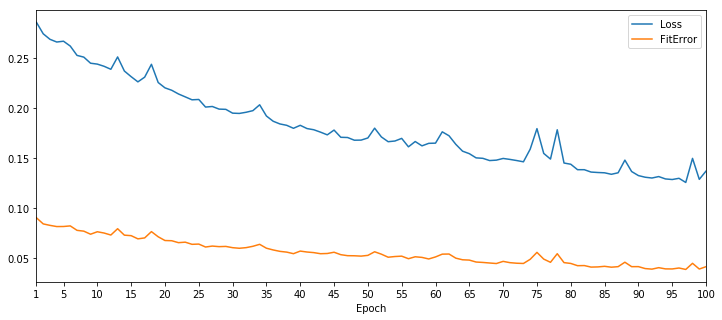

In [70]:
model.plot_training_history(tick_frequency=5)

In [71]:
model.evaluate(data=data[data['_PartInd_']==2],
               top_probs=2, 
               text_parms=TextParms(init_input_embeddings='emb'))

ERROR: The column I_cat does not exist in table VALID_RES_TVYGGI.
ERROR: The action stopped due to errors.


[ScoreInfo]

                                Descr         Value
 0        Number of Observations Read         16394
 1        Number of Observations Used         16394
 2        Misclassification Error (%)      81.57253
 3  Top 2 Misclassification Error (%)             0
 4                         Loss Error      0.036912

[OutputCasTables]

              casLib              Name   Rows  Columns  \
 0  CASUSER(sasdemo)  Valid_Res_TvygGi  16394       18   
 
                                             casTable  
 0  CASTable('Valid_Res_TvygGi', caslib='CASUSER(s...  

+ Elapsed: 4.35s, user: 9.05s, sys: 1.62s, mem: 731mb

In [72]:
#Crosstab


# Train New Embeddings

# Train New Model

# Save Models

# Terminate Session